## DNA methylation and age in bats

We are now ready to build our first **predictive machine**! <br>
First, we load the R packages that are needed for this analysis:

In [1]:
library("xlsx")
library("broom")
library("knitr")
library("dplyr")
library("ggplot2")
library("corrplot")
library("reshape2")
library("tidyverse")
library("tidymodels")

knitr::opts_chunk$set(echo = TRUE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


corrplot 0.88 loaded

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.1.6     ✔ purrr   0.3.4
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

## Reading the data

For this practical session on linear regression we are using a dataset on the relationship between the age of wild bats and DNA methylation at specific CpG sites ([data](https://datadryad.org/stash/dataset/doi:10.5061/dryad.rn0198d); [paper](https://onlinelibrary.wiley.com/doi/abs/10.1111/1755-0998.12925)).

The public dataset downloaded from Dryad is an `.xlsm` file, and can be read into *R* using the `read.xlsx()` function from the **xlsx** package.

In [2]:
ch4 <- read.xlsx("../data/DNA methylation data.xlsm", sheetIndex = 1)
ch4 %>%
  head()

,Sample,Age,Age.category,CpG.1.TET2,CpG.2.TET2,CpG.3.TET2,CpG.4.TET2,CpG.GRIA2.1,CpG.GRIA2.2,ASPA.1
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,BabyBechs_SHW,0,Age 0-3,29,21,26,31,2,2,61
2,Dd_Juv_Hamgreen,0,Age 0-3,30,21,24,32,1,2,59
3,A2402,1,Age 0-3,44,38,51,53,1,5,48
4,A2414-2014,1,Age 0-3,48,36,50,46,1,2,53
5,A8481-2014,1,Age 0-3,22,9,28,31,2,2,41
6,A8522-2015,1,Age 0-3,42,30,40,41,0,4,59


## Exploratory Data Analysis

The dataset contains the age of bats in years and the percentage methylation at 7 CpG sites (epigenetic modifications).

In [3]:
mCH4 <- reshape2::melt(ch4, id.vars = c("Sample","Age.category"), variable.name = "var")
mCH4 %>%
  group_by(var) %>%
  summarise(N = n(),
            n_missing = sum(is.na(value)),
            avg = round(mean(value, na.rm = TRUE),2),
            std = round(sd(value, na.rm = TRUE),2),
            min = min(value),
            max = max(value))

var,N,n_missing,avg,std,min,max
<fct>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
Age,62,0,5.61,3.67,0,14
CpG.1.TET2,62,0,56.55,10.21,22,71
CpG.2.TET2,62,0,46.69,10.06,9,62
CpG.3.TET2,62,0,60.35,11.00,24,74
CpG.4.TET2,62,0,53.08,7.15,31,70
CpG.GRIA2.1,62,2,2.93,1.90,NA,NA
CpG.GRIA2.2,62,2,3.87,1.84,NA,NA
ASPA.1,62,3,49.95,8.40,NA,NA


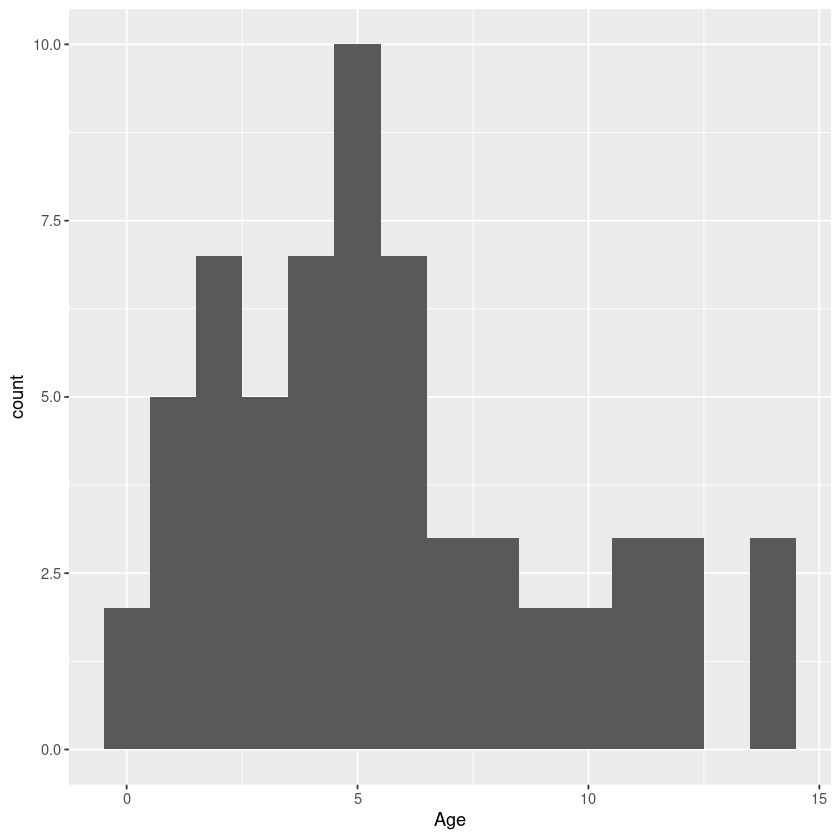

In [4]:
ggplot(data = ch4, aes(Age)) + geom_histogram(binwidth = 1)

The columns `Sample` and `Age.category` will not be used for the analysis:

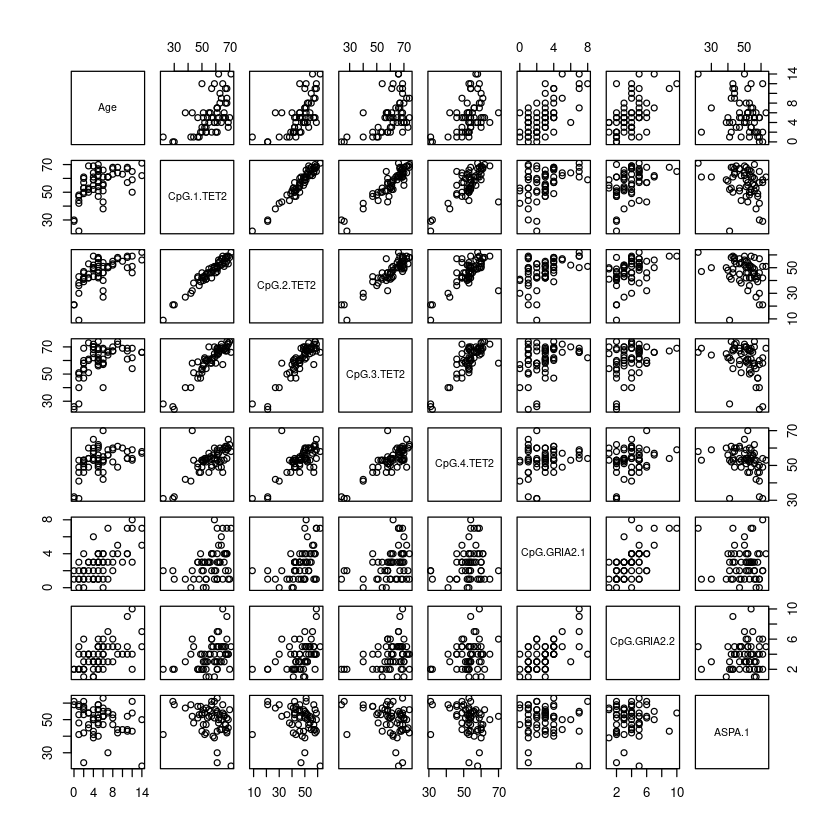

In [5]:
ch4 <- na.omit(ch4[,-c(1,3)])
plot(ch4)

#### Correlation matrix

In [6]:
M <- cor(ch4, use = "complete.obs")
M

,Age,CpG.1.TET2,CpG.2.TET2,CpG.3.TET2,CpG.4.TET2,CpG.GRIA2.1,CpG.GRIA2.2,ASPA.1
Age,1.0000000,0.5382834,0.6226773,0.5047107,0.4530825,0.65541933,0.52878914,-0.26525985
CpG.1.TET2,0.5382834,1.0000000,0.9665916,0.9191866,0.7323242,0.39084926,0.38827974,-0.27050789
CpG.2.TET2,0.6226773,0.9665916,1.0000000,0.9018010,0.7239004,0.46385705,0.40573894,-0.25407676
CpG.3.TET2,0.5047107,0.9191866,0.9018010,1.0000000,0.8291509,0.35183710,0.30537568,-0.31468689
CpG.4.TET2,0.4530825,0.7323242,0.7239004,0.8291509,1.0000000,0.19732616,0.25128779,-0.30107941
CpG.GRIA2.1,0.6554193,0.3908493,0.4638570,0.3518371,0.1973262,1.00000000,0.61660751,-0.03212135
CpG.GRIA2.2,0.5287891,0.3882797,0.4057389,0.3053757,0.2512878,0.61660751,1.00000000,0.07345754
ASPA.1,-0.2652599,-0.2705079,-0.2540768,-0.3146869,-0.3010794,-0.03212135,0.07345754,1.00000000


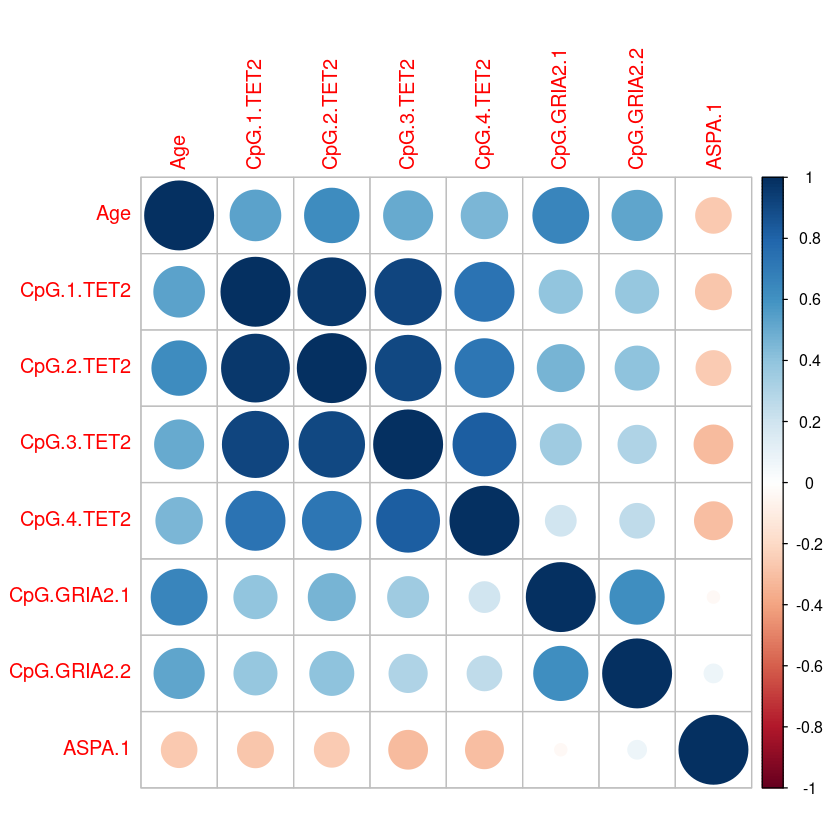

In [7]:
corrplot(M)

## Fitting the multiple linear regression model

$$
y_{ik} = \mu + \sum_{i=1}^k CpG_k + e_{ik}
$$

In [8]:
fit <- lm(Age ~ ., data = ch4)
tidy(fit)
r_squared <- summary(fit)$r.squared
print(paste("R^2 is: ", round(r_squared,3)))

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.36940622,3.56434129,0.3841962,0.702430340
CpG.1.TET2,-0.21811322,0.12888048,-1.6923681,0.096677436
CpG.2.TET2,0.35114818,0.12248450,2.8668784,0.006011536
CpG.3.TET2,-0.07675001,0.08429439,-0.9104996,0.366842476
CpG.4.TET2,0.10272420,0.07516845,1.3665866,0.177749756
CpG.GRIA2.1,0.68176302,0.22502014,3.0297866,0.003836340
CpG.GRIA2.2,0.33983286,0.21835386,1.5563401,0.125811660
ASPA.1,-0.08150147,0.03784772,-2.1534049,0.036037660


[1] "R^2 is:  0.645"


The coefficient of determination **$R^2$** is `r r_squared`

In [9]:
data.frame("coefficient"=coef(fit))

,coefficient
,<dbl>
(Intercept),1.36940622
CpG.1.TET2,-0.21811322
CpG.2.TET2,0.35114818
CpG.3.TET2,-0.07675001
CpG.4.TET2,0.10272420
CpG.GRIA2.1,0.68176302
CpG.GRIA2.2,0.33983286
ASPA.1,-0.08150147


## Predictions

We start by manually predicting one observation $i$ from the estimated coefficients and the feature vector $x_i$

In [10]:
n <- sample(nrow(ch4),1) ## we sample one record to predict
x <- as.matrix(ch4[n,-1])
x <- c(1,x) ## add intercept
y <- ch4[n,1]
coefs <- as.vector(coef(fit))
print(paste("actual observation:", y, "years"))
print(paste("methylation at CpG sites for the samples individual: ", paste(x, collapse = " ")))
print(paste("estimated model coefficients:", paste(round(coefs,3), collapse = " ")))

[1] "actual observation: 1 years"
[1] "methylation at CpG sites for the samples individual:  1 42 30 40 41 0 4 59"
[1] "estimated model coefficients: 1.369 -0.218 0.351 -0.077 0.103 0.682 0.34 -0.082"


In [11]:
y_hat = t(coefs) %*% x
print(c(y,y_hat))
error = y - y_hat
print(error)

[1] 1.0000000 0.4355324
          [,1]
[1,] 0.5644676


Our prediction is `r y_hat`; the corresponding observation is `r y`; hence the prediction error is `r error`.

We then predict all observations using the `predict()` function:

In [12]:
predictions <- predict(fit,ch4[,-1],interval="none", type = "response", na.action=na.pass)

cbind(ch4, predictions) %>% head(10)

,Age,CpG.1.TET2,CpG.2.TET2,CpG.3.TET2,CpG.4.TET2,CpG.GRIA2.1,CpG.GRIA2.2,ASPA.1,predictions
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,29,21,26,31,2,2,61,0.6787862
2,0,30,21,24,32,1,2,59,0.1981372
3,1,44,38,51,53,1,5,48,5.1150437
4,1,48,36,50,46,1,2,53,1.4709692
5,1,22,9,28,31,2,2,41,-0.5316699
6,1,42,30,40,41,0,4,59,0.4355324
7,1,47,43,47,49,3,2,58,5.6415609
8,2,61,47,69,53,1,2,24,4.1224892
9,2,50,42,53,53,2,2,53,4.3122142


Finally, we can measure the predictive performance of the model:

In [13]:
r_pearson = cor(ch4$Age,predictions)
r_spearman = cor(ch4$Age,predictions, method = "spearman")
mse = mean((ch4$Age-predictions)^2)
rmse = sqrt(mse)
nrmse = sqrt(mse)/mean(ch4$Age)

data.frame("metric"=c("MSE","RMSE","NRMSE","r pearson","r spearman"),
           "value"=c(mse,rmse,nrmse,r_pearson,r_spearman))

metric,value
<chr>,<dbl>
MSE,4.3595727
RMSE,2.0879590
NRMSE,0.3837682
r pearson,0.8031170
r spearman,0.7524877


#### Visuliazing results

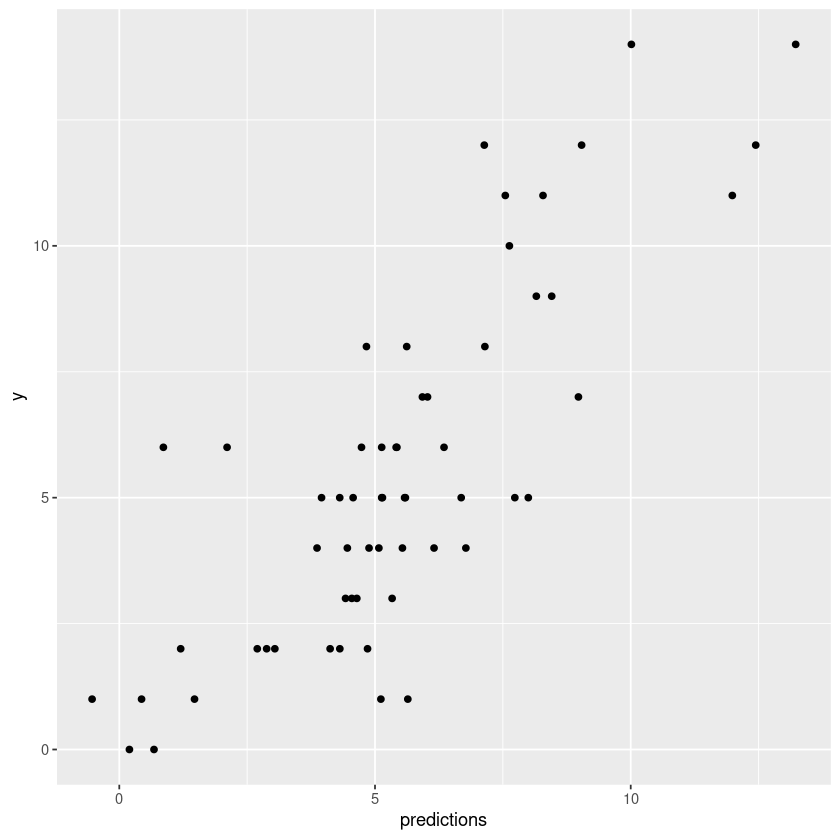

In [14]:
ggplot(data.frame("y"=ch4$Age,"predictions"=predictions), aes(x=predictions,y=y)) +
  geom_point()

### Normalised Discounted Cumulative Gain

**NDCG** (Normalised Discounted Cumulative Gain)

Gain function

$$
g(y_{\pi}) = y[\pi(\hat{y})]
$$

In [15]:
g = ch4$Age[order(predictions,decreasing = TRUE)]
g

[1] 14 12 11 14 12  7  9 11  9  5  5 10 11  8 12  4  5  6  4  7  7  1  8  5  5
[26]  4  6  6  3  5  6  5  1  4  4  2  8  6  3  5  3  4  3  2  5  2  5  4  2  2
[51]  2  6  1  2  6  0  1  0  1

If predictions are accurate, you should see (above) that when ordered based on predictions (gain function) the oldest bats are on top, and the youngest bats are at the bottom of the rank.

Discount:

$$
d(i) = \frac{1}{log_2(i+1)}
$$

Discounted cumulative gain:

$$
DCG@k = \sum_{i=1}^k g(y_{\pi_i}) \cdot d(i) 
$$

The top ranked observations have the highest weight ("discount"), while the lower ranked observations get lower weights following the hyperbolic curve below (asymptotically going towards zero as the number of top ranked observations considered increases, without ever reaching it)

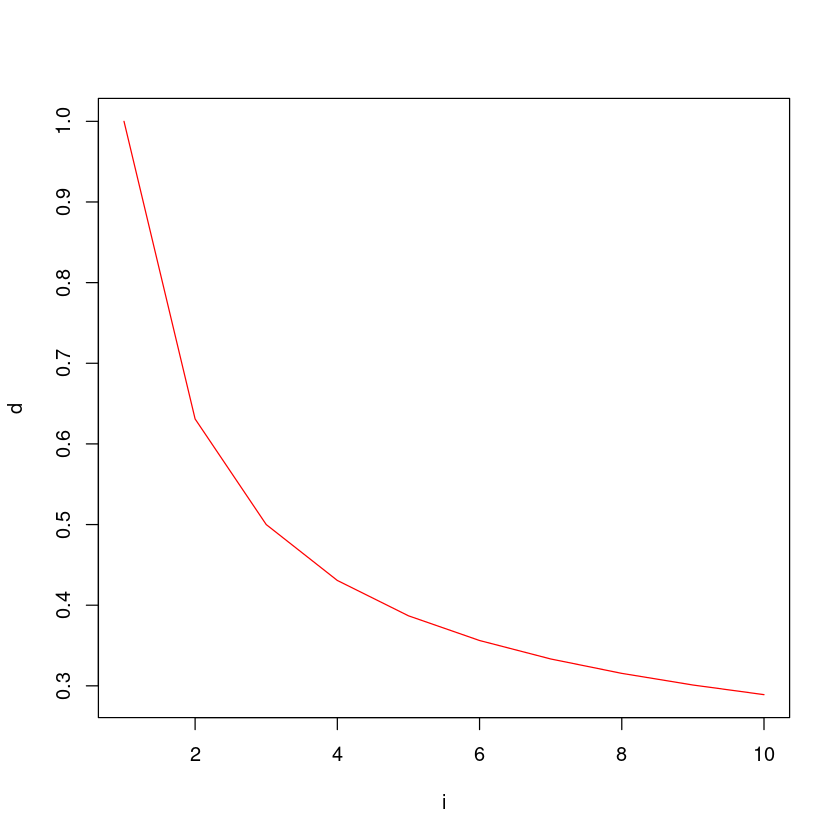

In [16]:
i = seq(1,10)
d = 1/(log2(i+1))

plot(i, d, type="l", col="red")

Example for $k=2$ (top 2 individuals in the ranking)

In [17]:
k = 2
gk = g[1:k] ## top two observed values according to ordered predictions
print(paste("top k obs ordered based on predictions",paste(gk, collapse = " ")))
d = 1/log(x = 1+1:k, base = 2)
dcg = sum(gk*d)
print(paste("cumulative discounted gain of the top k observations", dcg))

[1] "top k obs ordered based on predictions 14 12"
[1] "cumulative discounted gain of the top k observations 21.5711570428575"


*DCG* is `r dcg`: high? low? We must normalise:

In [18]:
denominator = ch4$Age[order(ch4$Age,decreasing = TRUE)]
print(denominator) ## perfect ordering
ndcg = dcg/sum(denominator[1:k]*d)
print(paste("NDCG is",ndcg))

 [1] 14 14 12 12 12 11 11 11 10  9  9  8  8  8  7  7  7  6  6  6  6  6  6  6  5
[26]  5  5  5  5  5  5  5  5  5  4  4  4  4  4  4  4  3  3  3  3  2  2  2  2  2
[51]  2  2  1  1  1  1  1  0  0
[1] "NDCG is 0.944735313252208"


*NDCG* is `r ndcg`.

Below a function to compute NDCG:


In [19]:
#Function to calculate Mean Normalized discounted cumulative gain (MNV)
ndcg <- function(y_hat,y,k) {
  
  y.sort_y_hat = y[order(y_hat,decreasing=TRUE)]
  y.sort_y = y[order(y,decreasing=TRUE)]
  d <- 1/log2(1+1:k)
  
  ndcg = sum(y.sort_y_hat[1:k]*d)/sum(y.sort_y[1:k]*d)

  return(ndcg)
}

In [20]:
NDCG <- ndcg(y_hat = predictions, y = ch4$Age, k = 10)
print(round(NDCG,4))

[1] 0.9196


## Exercise 2.1 (optional)

- write your own model: remove variables, add interactions, quadratic effects etc.
- measure the performance of your model

In [ ]:
## write your code here